### This notebook contains recap of Prophet, LightGBM, and all other ensemble methods.

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import matplotlib.pyplot as plt
import math
#Bagging and Boosting libraries
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor
#from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.ensemble import BaggingRegressor
#Stacking:
from sklearn.ensemble import StackingRegressor,RandomForestRegressor
from sklearn.linear_model import LinearRegression

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('C:/Users/Deepak/Desktop/Manuscript prep/sales_train_validation.csv')
#All category items are grouped together to create a target variable

df.drop(columns=['item_id', 'dept_id','store_id','state_id'],axis=1, inplace=True) 
data = df.T
data.columns = df['cat_id'] 
data.index.name = None   
data.drop(index='id',inplace=True) 
data.drop(index='cat_id',inplace=True) 
data.columns.name = None 
 
calendar = pd.read_csv('C:/Users/Deepak/Desktop/Manuscript prep/calendar.csv')
data.index = calendar['date'][0:1913]
df_cat = data.groupby(level=0, axis=1).sum()

#All department items are grouped together to create a target variable

df = pd.read_csv('C:/Users/Deepak/Desktop/Manuscript prep/sales_train_validation.csv')
df.drop(columns=['item_id', 'cat_id','store_id','state_id'],axis=1, inplace=True) 
data = df.T
data.columns = df['dept_id'] 
data.index.name = None   
data.drop(index='id',inplace=True) 
data.drop(index='dept_id',inplace=True) 
data.columns.name = None 

calendar = pd.read_csv('C:/Users/Deepak/Desktop/Manuscript prep/calendar.csv')
data.index = calendar['date'][0:1913]
df_dept = data.groupby(level=0, axis=1).sum()

#State-wise categorization
df = pd.read_csv('C:/Users/Deepak/Desktop/Manuscript prep/sales_train_validation.csv')
df.drop(columns=['item_id', 'dept_id','store_id','cat_id'],axis=1, inplace=True) 
data = df.T
data.columns = df['state_id'] 
data.index.name = None   
data.drop(index='id',inplace=True) 
data.drop(index='state_id',inplace=True) 
data.columns.name = None 
 
calendar = pd.read_csv('C:/Users/Deepak/Desktop/Manuscript prep/calendar.csv')
data.index = calendar['date'][0:1913]
df_state = data.groupby(level=0, axis=1).sum()

#Store-wise categorization
df = pd.read_csv('C:/Users/Deepak/Desktop/Manuscript prep/sales_train_validation.csv')
df.drop(columns=['item_id', 'dept_id','state_id','cat_id'],axis=1, inplace=True) 
data = df.T
data.columns = df['store_id'] 
data.index.name = None   
data.drop(index='id',inplace=True) 
data.drop(index='store_id',inplace=True) 
data.columns.name = None 
 
calendar = pd.read_csv('C:/Users/Deepak/Desktop/Manuscript prep/calendar.csv')
data.index = calendar['date'][0:1913]
df_store = data.groupby(level=0, axis=1).sum()
#Concat all dataframes
df = pd.concat([df_cat,df_dept,df_state,df_store, ], axis=1)
df.head(1)

,FOODS,HOBBIES,HOUSEHOLD,FOODS_1,FOODS_2,FOODS_3,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2,...,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,23178,3764,5689,2343,4094,16741,3610,154,4105,1584,...,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038


In [3]:
df['ds'] = df.index.values

# Convert the 'ds' column to datetime type
df['ds'] = pd.to_datetime(df['ds'])
#df.head()

In [4]:
# Split the data into train and test sets

train_size = int(len(df) * 0.8)  # 80% for training
train, test = df[:train_size], df[train_size+1:]

In [5]:
# train data has 2011-01-29 to 2015-04-07 (1530 rows) and test data has 2015-04-09 to 2016-04-24 (382 rows)
len(train),len(test)

(1530, 382)

In [6]:
target_columns = ['FOODS','HOBBIES','HOUSEHOLD','FOODS_1','FOODS_2','FOODS_3','HOBBIES_1','HOBBIES_2','HOUSEHOLD_1',
                  'HOUSEHOLD_2','CA','TX','WI','CA_1','CA_2','CA_3','CA_4','TX_1','TX_2','TX_3','WI_1','WI_2','WI_3']

In [7]:
# Fit Prophet models for each target variable
prophet_models = {}
for column in target_columns:
    # Rename the columns to 'ds' and 'y'
    train_target = train[[column]].rename(columns={column: 'y'})
    train_target['ds'] = train.index
    
    model = Prophet()
    model.fit(train_target)
    prophet_models[column] = model

22:40:40 - cmdstanpy - INFO - Chain [1] start processing
22:40:40 - cmdstanpy - INFO - Chain [1] done processing
22:40:40 - cmdstanpy - INFO - Chain [1] start processing
22:40:40 - cmdstanpy - INFO - Chain [1] done processing
22:40:40 - cmdstanpy - INFO - Chain [1] start processing
22:40:41 - cmdstanpy - INFO - Chain [1] done processing
22:40:41 - cmdstanpy - INFO - Chain [1] start processing
22:40:41 - cmdstanpy - INFO - Chain [1] done processing
22:40:41 - cmdstanpy - INFO - Chain [1] start processing
22:40:41 - cmdstanpy - INFO - Chain [1] done processing
22:40:41 - cmdstanpy - INFO - Chain [1] start processing
22:40:41 - cmdstanpy - INFO - Chain [1] done processing
22:40:42 - cmdstanpy - INFO - Chain [1] start processing
22:40:42 - cmdstanpy - INFO - Chain [1] done processing
22:40:42 - cmdstanpy - INFO - Chain [1] start processing
22:40:42 - cmdstanpy - INFO - Chain [1] done processing
22:40:42 - cmdstanpy - INFO - Chain [1] start processing
22:40:42 - cmdstanpy - INFO - Chain [1]

In [8]:
# Make predictions on the test set
predictions = {}
for column in target_columns:
    model = prophet_models[column]
    
    # Create future dataframe for predictions
    future = model.make_future_dataframe(periods=len(test))
    
    # Rename the columns to 'ds'
    future = future.rename(columns={'ds': 'ds'})
    
    # Make predictions
    #The .tail(len(test))` part ensures that only the predictions for the test set are stored.
    forecast = model.predict(future)
    predictions[column] = forecast['yhat'].tail(len(test))

In [9]:
# Calculate MAPE and RMSE for each target variable
mape = {}
rmse = {}
for column in target_columns:
    actual = test[column].values.astype('float64')
    predicted = predictions[column].values
    mape[column] = mean_absolute_percentage_error(actual, predicted)
    rmse[column] = np.sqrt(mean_squared_error(actual, predicted))

In [10]:
RMSE = []
MAPE = []

for column in target_columns:
    MAPE.append(mape[column])
    RMSE.append(rmse[column])

print("RMSE_Prophet:", RMSE)
print("MAPE_Prophet:", MAPE)

RMSE_Prophet: [5110.8235284834445, 558.8647341927426, 1585.081735746497, 595.9981400812075, 1191.0193788538754, 3876.755636485078, 543.9021764641608, 160.33901493306325, 1303.2539654376048, 311.0364441083963, 3382.0284501647966, 1710.260102149567, 2485.536906698374, 792.7791747591133, 2074.6689294284483, 903.3300883035496, 312.77741656797383, 531.7544317221472, 710.301955475194, 556.4151381998163, 709.4270412204864, 1043.5941966349826, 1081.5826116893172]
MAPE_Prophet: [3.99210937291565, 3.9691575402403624e+16, 19.25785074713275, 7.404256954580688, 4.5102391159932344e+16, 2.8077851936001212, 3.392133001457955e+16, 5919047719780340.0, 6.847756335045825e+16, 4.0406680748275186, 5.201140553356924, 5.671856052364931, 6.053214668006202, 4.223807952361279e+16, 2.1972074429071773, 3.2130101947456073, 2.229458591990114e+16, 6.9712924887946, 3.3624949938388588e+16, 2.8330835813912802, 4.636563812586893, 9.528352523287227, 5.836580526735573]


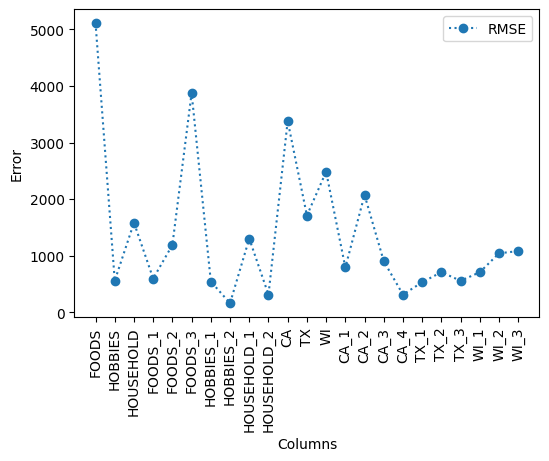

In [11]:
# Plot the RMSE values
plt.figure(figsize=(6,4))
plt.plot(target_columns, RMSE, marker='o', linestyle='dotted', label='RMSE')
plt.xticks(rotation=90)
plt.xlabel('Columns')
plt.ylabel('Error')
plt.legend()
plt.show()

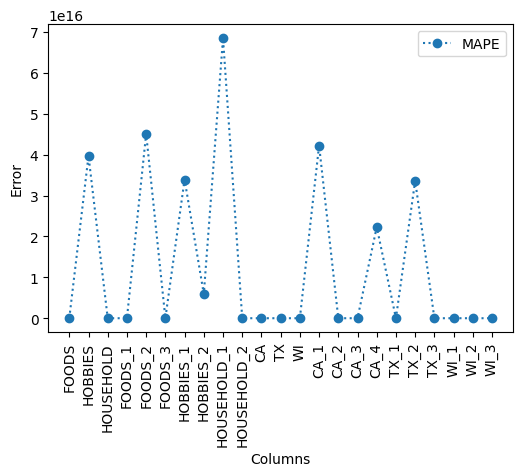

In [12]:
# Plot the MAPE values
plt.figure(figsize=(6, 4))
plt.plot(target_columns, MAPE, marker='o', linestyle='dotted', label='MAPE')
plt.xticks(rotation=90)
plt.xlabel('Columns')
plt.ylabel('Error')
plt.legend()
plt.show()

### XGBOOST

In [13]:
# The 'ds' column in the `train` and `test` DataFrames is converted from a datetime data type to a numerical representation.
#This is necessary because the XGBoost library does not support datetime columns by default.

train['ds'] = pd.to_numeric(train['ds'])
test['ds'] = pd.to_numeric(test['ds'])

C:\Users\Deepak\AppData\Local\Temp\ipykernel_4264\211572185.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['ds'] = pd.to_numeric(train['ds'])
C:\Users\Deepak\AppData\Local\Temp\ipykernel_4264\211572185.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ds'] = pd.to_numeric(test['ds'])


In [14]:
# Fit XGBoost models for each target variable.
'''This code iterates over each target column and fits an XGBoost regressor model to predict that column. 
The predictor variables are obtained by dropping the target column from the `train` DataFrame. 
The fitted models are stored in a dictionary called `models`, with the target column name as the key'''

models = {}
for column in target_columns:
    X_train = train.drop(column, axis=1)
    y_train = train[column]
    
    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)
    models[column] = model

# Make predictions on the test set
predictions = {}
for column in target_columns:
    model = models[column]
    X_test = test.drop(column, axis=1)
    
    y_pred = model.predict(X_test)
    predictions[column] = y_pred

In [15]:
RMSE = []
for column in target_columns:
    y_true = test[column]
    y_pred = predictions[column]
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    RMSE.append(rmse)

print("RMSE_XGBoost:", RMSE)

RMSE_XGBoost: [684.5201518781283, 58.32733658907493, 133.43926140001807, 432.27354609851494, 910.3908680489494, 506.78743602515453, 60.8622305373713, 96.89834073141365, 130.46233828315331, 144.22878194526086, 696.4173183222433, 264.2913221138851, 344.33383229528016, 380.4926819621933, 1276.8889879924964, 432.8312179600542, 161.1345705527386, 161.4462891527314, 186.5938990504928, 292.93124724825554, 356.38277625452577, 426.3690554448898, 277.1735669399432]


### Bagging

In [16]:
# Fit BaggingRegressor models for each target variable
models = {}
for column in target_columns:
    X_train = train.drop(column, axis=1)
    y_train = train[column]
    
    model = BaggingRegressor(base_estimator=xgb.XGBRegressor(), n_estimators=10)
    model.fit(X_train, y_train)
    models[column] = model

# Make predictions on the test set
predictions = {}
for column in target_columns:
    model = models[column]
    X_test = test.drop(column, axis=1)
    
    y_pred = model.predict(X_test)
    predictions[column] = y_pred

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `e

In [17]:
RMSE = []
for column in target_columns:
    y_true = test[column]
    y_pred = predictions[column]
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    RMSE.append(rmse)

print("RMSE_Bagging:", RMSE)

RMSE_Bagging: [700.4835860184363, 55.847449969224186, 156.18206030519926, 360.5270346284518, 978.7569319501753, 472.5726214270837, 44.649449453601555, 98.59547055840675, 144.389113650693, 149.42313157411928, 739.8917798968009, 245.13246568431373, 380.39184049767067, 421.09473325231716, 1282.7736056721878, 436.7577006468604, 155.5055369689482, 160.00980249948282, 164.4774509142864, 218.26660040162312, 300.6900323561019, 433.78772453008025, 289.06788370091294]


### Stacking

In [18]:
# Fit StackingRegressor models for each target variable
stacking_models = {}
for column in target_columns:
    X_train = train.drop(column, axis=1)
    y_train = train[column]
    
    estimators = [
        ('xgb', xgb.XGBRegressor()),
        ('bagging', BaggingRegressor(base_estimator=xgb.XGBRegressor(), n_estimators=10))
    ]
    
    model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
    model.fit(X_train, y_train)
    
    stacking_models[column] = model

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `e

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `e

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `e

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `e

In [19]:
# Make predictions on the test set using the stacking models
stacking_predictions = {}
for column in target_columns:
    model = stacking_models[column]
    X_test = test.drop(column, axis=1)
    
    y_pred = model.predict(X_test)
    stacking_predictions[column] = y_pred

In [20]:
# Calculate the RMSE for each target column
stacking_RMSE = []
for column in target_columns:
    y_true = test[column]
    y_pred = stacking_predictions[column]
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    stacking_RMSE.append(rmse)

print("RMSE_Stacking:", stacking_RMSE)

RMSE_Stacking: [598.3548821913953, 56.23766569984599, 127.1712773224984, 349.49304034812224, 978.1951427996008, 495.7818289858393, 59.28081033776238, 104.63893216560304, 131.6555950759376, 146.46032694919052, 681.7344600048328, 262.327241305149, 315.86550705247475, 425.15460102050776, 1265.664151643563, 443.7559710995498, 165.42161416021912, 167.85457651932435, 191.04354179036733, 284.18922190204574, 429.82879471445966, 433.20362346265256, 256.1446031057498]


### Stacking using meta-learners (Random Forest Regressor)

In [21]:
# Fit StackingRegressor models for each target variable
stacking_models = {}
for column in target_columns:
    X_train = train.drop(column, axis=1)
    y_train = train[column]
    
    estimators = [
        ('xgb', xgb.XGBRegressor()),
        ('bagging', BaggingRegressor(base_estimator=xgb.XGBRegressor(), n_estimators=10))
    ]
    
    meta_learner = RandomForestRegressor()  # Meta-learner model, can be any regression model
    
    stacking_model = StackingRegressor(estimators=estimators, final_estimator=meta_learner)
    stacking_model.fit(X_train, y_train)
    
    stacking_models[column] = stacking_model

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `e

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `e

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `e

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `e

In [22]:
# Make predictions on the test set using the stacking models
stacking_predictions = {}
for column in target_columns:
    stacking_model = stacking_models[column]
    X_test = test.drop(column, axis=1)
    
    y_pred = stacking_model.predict(X_test)
    stacking_predictions[column] = y_pred

In [23]:
# Calculate the RMSE for each target column
stacking_meta_learner_RMSE = []
for column in target_columns:
    y_true = test[column]
    y_pred = stacking_predictions[column]
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    stacking_meta_learner_RMSE.append(rmse)

print("RMSE_Stacking for Random Forest Regressor:", stacking_meta_learner_RMSE)

RMSE_Stacking for Random Forest Regressor: [618.6802117169719, 61.28898608809585, 266.88381109502944, 403.31487628686995, 884.0220137416504, 542.1496141328981, 69.9933463386013, 113.03198329055745, 159.87376505096356, 170.97882807605677, 599.5738873348489, 259.93166300030606, 508.6689126204709, 476.9452318020838, 1259.9641745570696, 481.37015201891364, 183.32161436517927, 189.43934682130788, 189.96507195351379, 239.50690263910997, 662.963845327965, 444.9201352925528, 287.3060094220098]


### FORECAST Plot with Stacking (Random Forest regressor)

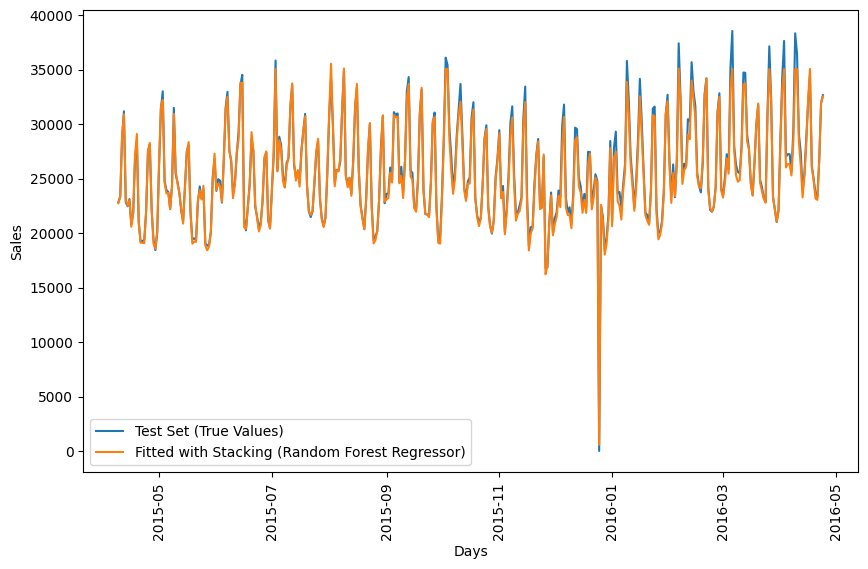

In [33]:
# Plotting test dataset and predicted dataset for 'FOODS' column
y_true = test['FOODS']
y_pred = stacking_predictions['FOODS']

plt.figure(figsize=(10, 6))
plt.plot(y_true.index, y_true, label='Test Set (True Values)')
plt.plot(y_true.index, y_pred, label='Fitted with Stacking (Random Forest Regressor)')
plt.xlabel('Days')
plt.ylabel('Sales')
plt.legend()
#plt.title('Test vs Predicted for FOODS')
plt.xticks(rotation = 90)
plt.show()

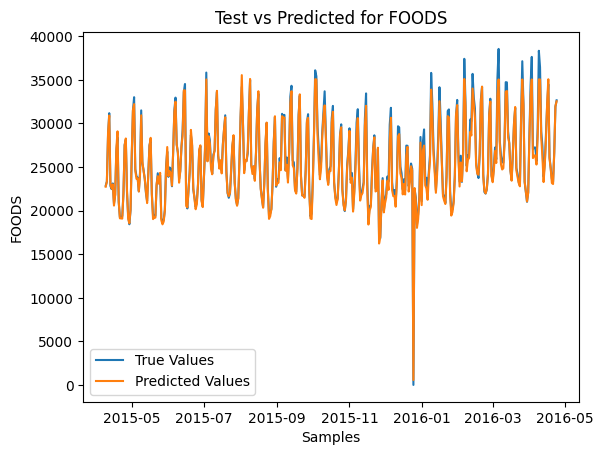

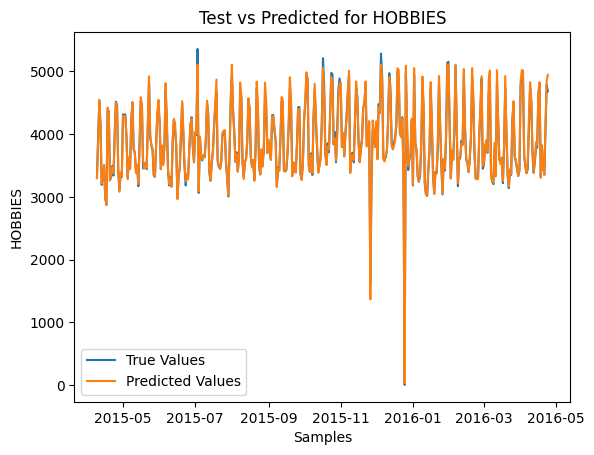

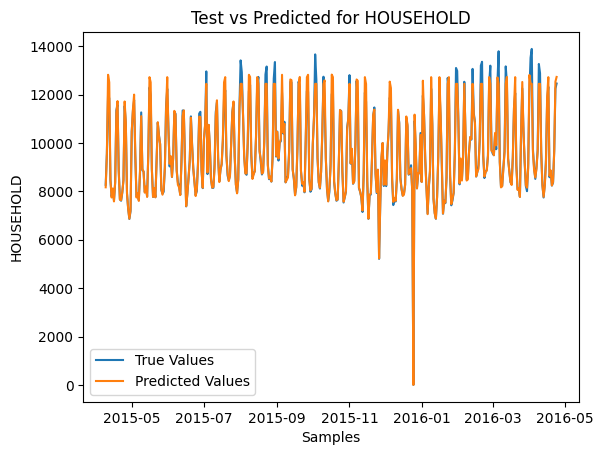

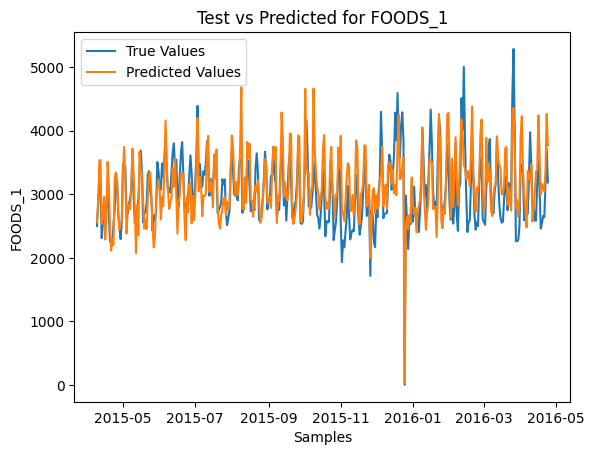

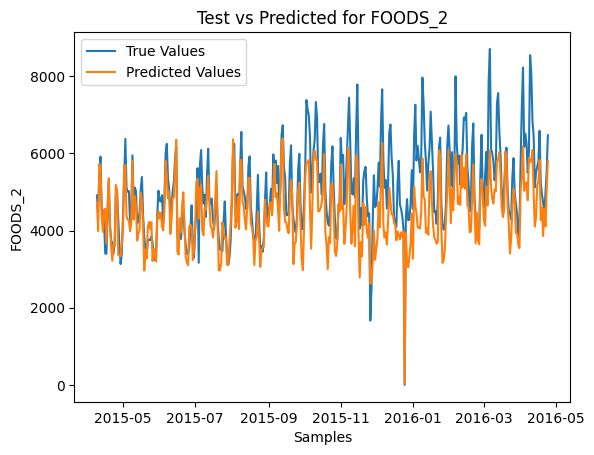

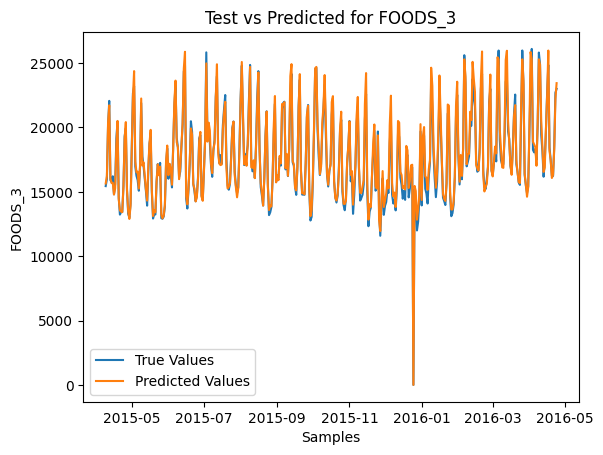

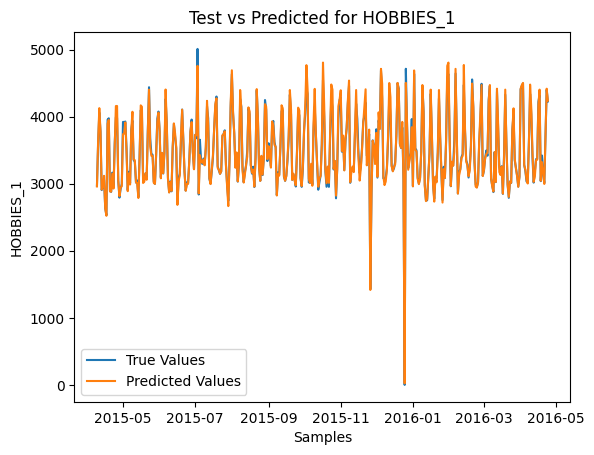

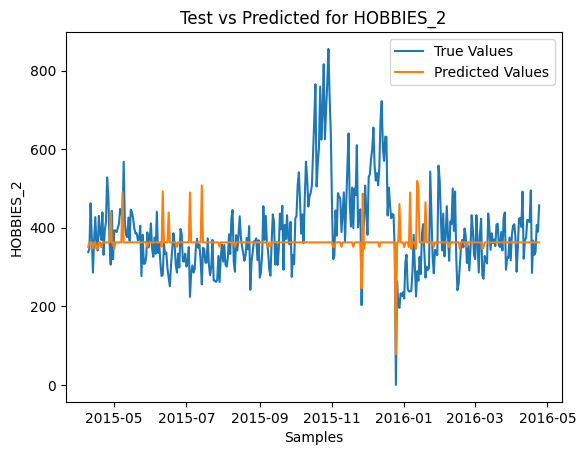

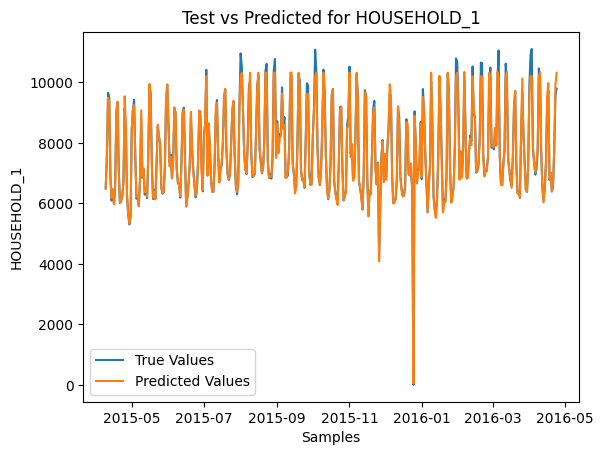

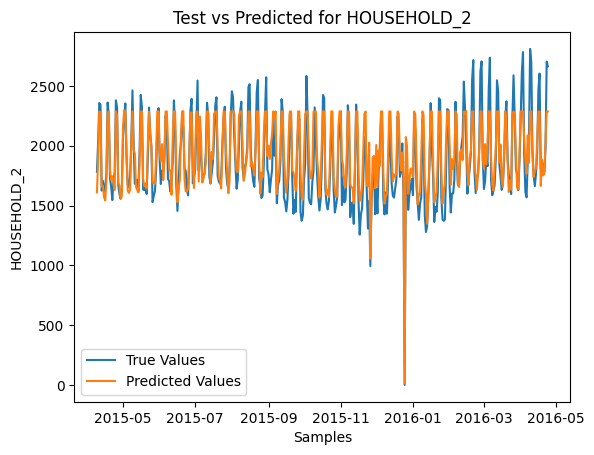

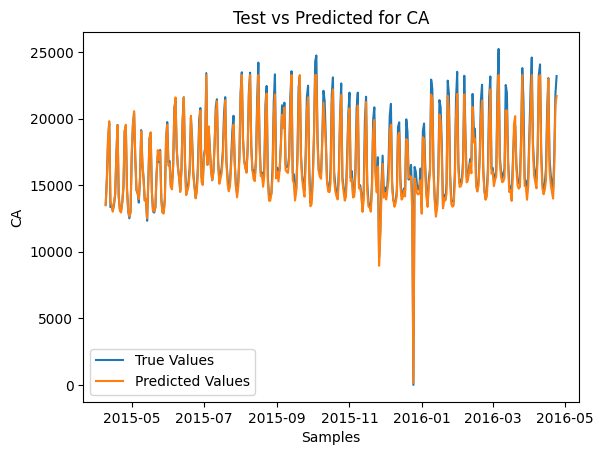

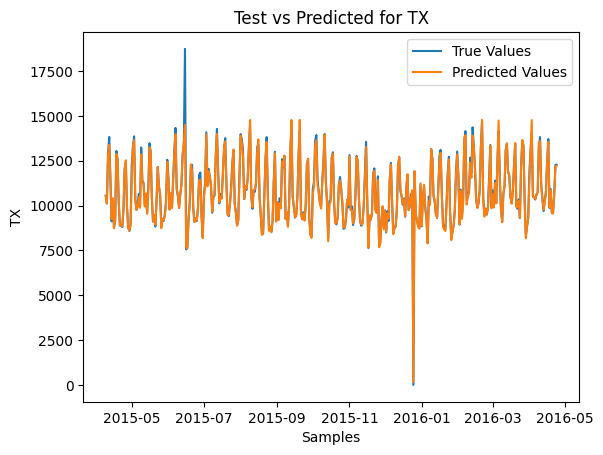

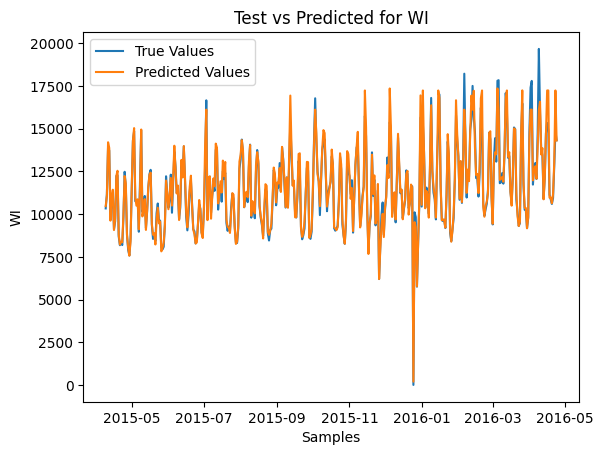

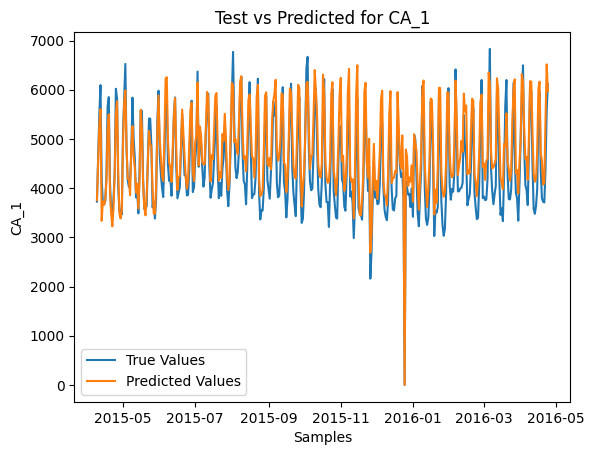

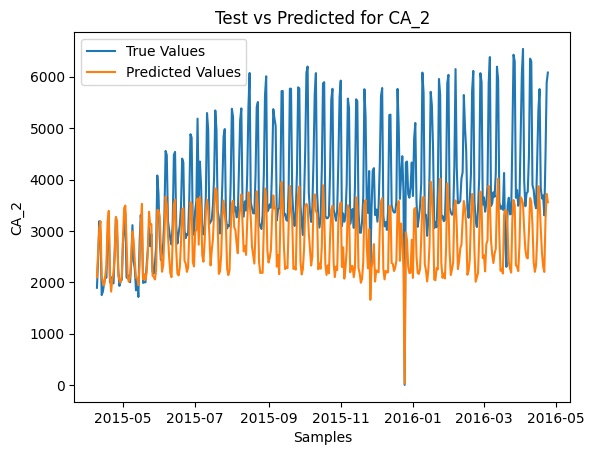

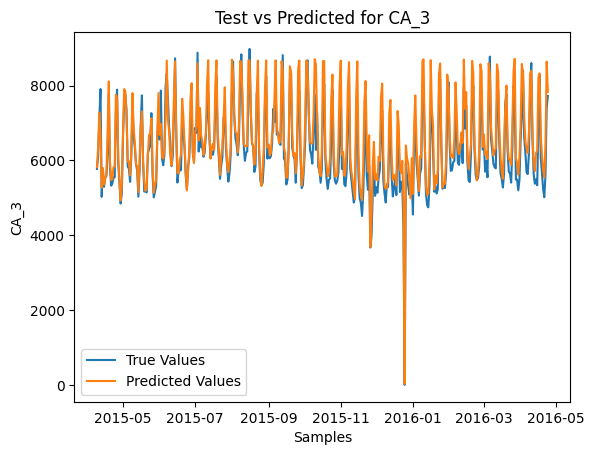

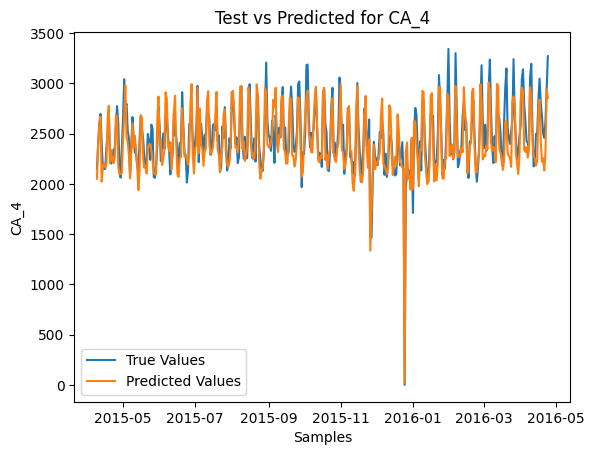

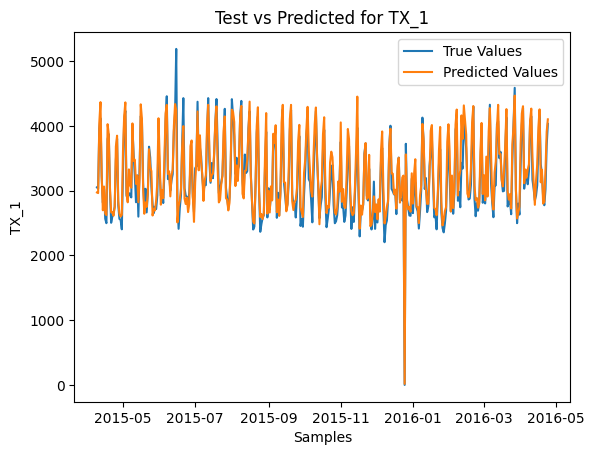

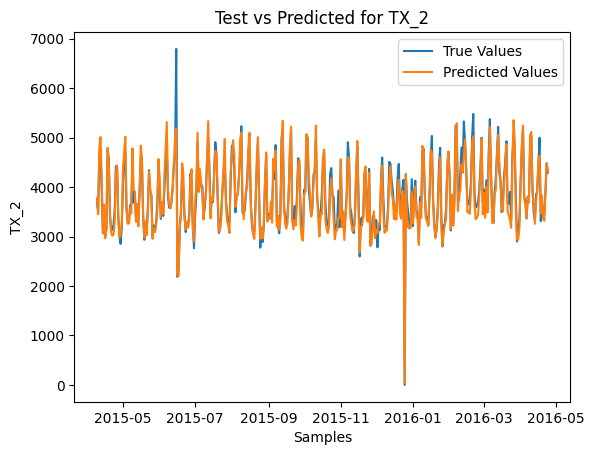

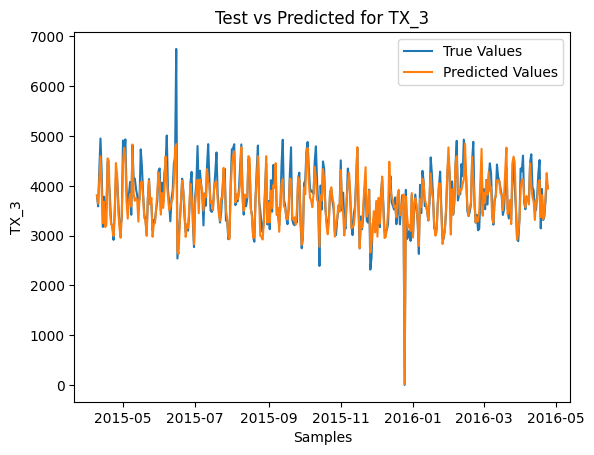

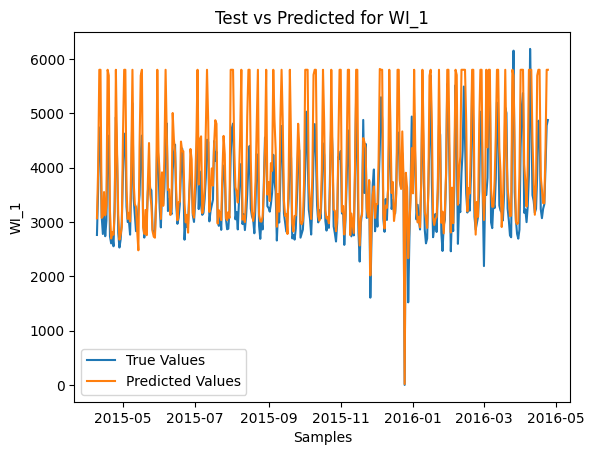

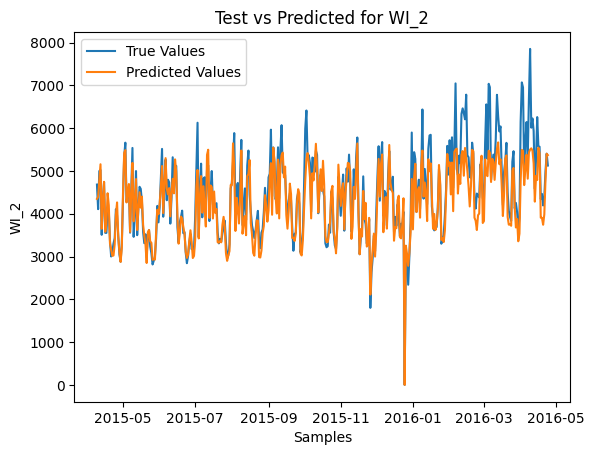

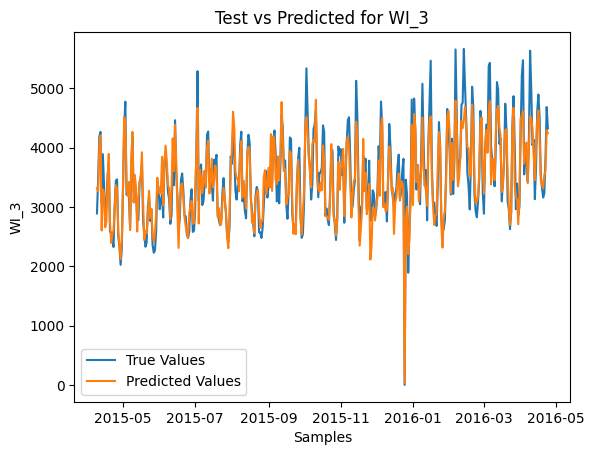

In [29]:
# Plotting test dataset and predicted dataset
for column in target_columns:
    y_true = test[column]
    y_pred = stacking_predictions[column]
    
    plt.figure()
    plt.plot(y_true.index, y_true, label='True Values')
    plt.plot(y_true.index, y_pred, label='Predicted Values')
    plt.xlabel('Samples')
    plt.ylabel(column)
    plt.legend()
    plt.title(f'Test vs Predicted for {column}')
    plt.show()

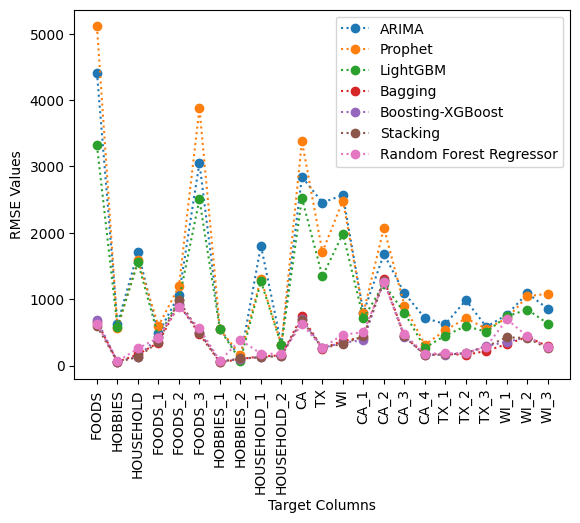

In [28]:
target_cols = ['FOODS','HOBBIES','HOUSEHOLD','FOODS_1','FOODS_2','FOODS_3','HOBBIES_1','HOBBIES_2','HOUSEHOLD_1',
               'HOUSEHOLD_2','CA', 'TX','WI','CA_1','CA_2', 'CA_3','CA_4', 'TX_1', 'TX_2', 'TX_3','WI_1','WI_2', 'WI_3']  

ARIMA = [4414.427801036455,625.0129703702443,1708.9953500272914,487.1101013596283,1062.1228870227712,3053.347541667216,
  555.4494543218098,107.7151437045555,1805.211932364774,314.772886635246,2845.1658686836577,2455.6378820617315,2568.189448239621,
  796.0200794610948,1679.6588711859101,1089.7251686454244,714.4705377660863,624.2840181834466,983.8099082992557,
  582.2712860138937,765.2309697498303,1090.065208980127,853.7038134989234]

Prophet =  [5110.8235284834445, 558.8647341927426, 1585.081735746497, 595.9981400812075, 1191.0193788538754, 3876.755636485078, 
            543.9021764641608, 160.33901493306325, 1303.2539654376048, 311.0364441083963, 3382.0284501647966, 
            1710.260102149567, 2485.536906698374, 792.7791747591133, 2074.6689294284483, 903.3300883035496, 
            312.77741656797383, 531.7544317221472, 710.301955475194, 556.4151381998163, 709.4270412204864, 
            1043.5941966349826, 1081.5826116893172]

LightGBM = [3319.590534537011,584.3977140491161, 1556.3873564216303, 433.0666251027355, 983.883585620006, 2503.339659573278,
            546.1107184801933,74.0229975877067,1270.1774091024874,304.5712510724757, 2522.012126488803, 1344.2516137774141,
            1986.7149140411043,710.8527467603836, 1227.410039106039, 794.9171988255989, 267.32320301143085, 451.72115419990445,
            595.0289127363693, 507.97801283937685,741.5630069409465, 843.1657277152618, 631.853972936856]

XGBoost = [684.5201518781283, 58.32733658907493, 133.43926140001807, 432.27354609851494, 910.3908680489494, 
                506.78743602515453, 60.8622305373713, 96.89834073141365, 130.46233828315331, 144.22878194526086, 
                696.4173183222433, 264.2913221138851, 344.33383229528016, 380.4926819621933, 1276.8889879924964, 
                432.8312179600542, 161.1345705527386, 161.4462891527314, 186.5938990504928, 292.93124724825554, 
                356.38277625452577, 426.3690554448898, 277.1735669399432]

Bagging = [658.8102849331476, 55.433439682131464, 165.97897202010964, 345.8699716991141, 925.228487183954, 
               474.80221120287734, 46.46854076152143, 97.82103218555623, 138.6758167808733, 151.39792802276364, 
               743.6384751084347, 256.08298820570775, 373.1195584400961, 420.3021208629403, 1301.432930106316, 
               439.63596372481373, 166.91434936063823, 174.79945210450302, 160.41951450339675, 219.86665617502976, 
               322.13404994399076, 432.28334927148603, 288.37137697853217]

Stacking = [595.507174429319, 56.409265688546775, 126.94033565664685, 356.86626415714414, 983.7996527412449, 
            495.4830393432965, 56.92251452223829, 105.8728796852712, 123.2754222116051, 146.009488626472, 
            680.6572166263741, 262.64642932613253, 327.08592544028795, 442.31215840655796, 1270.2362588853962, 
            445.0209901599056, 162.5979809497748, 166.9886968461545, 184.1980911654955, 286.4085760611746, 
            424.9553886337423, 413.9047181932017, 256.70817059808843]

RF_Regressor =[627.3532723343671, 61.758482773645106, 256.54148181815646, 421.76245512229434, 887.717741046583, 
               560.510961326841, 69.18899978770494, 387.0589292079194, 177.06062308463845, 176.5113281274883, 
               626.5962857347598, 267.07718729822454, 466.43248809952337, 499.7887126505879, 1251.5735015651926,
               468.17863408323313, 178.55342397396703, 183.4916998836133, 190.46807963939344, 283.59175479359584, 
               697.8609639063076, 438.7109411023754, 277.8611247326555]

plt.plot(target_cols, ARIMA, marker='o', linestyle='dotted', label="ARIMA")
plt.plot(target_cols, Prophet, marker='o', linestyle='dotted', label="Prophet")
plt.plot(target_cols, LightGBM, marker='o', linestyle='dotted', label="LightGBM")
plt.plot(target_cols, Bagging, marker='o', linestyle='dotted', label="Bagging")
plt.plot(target_cols, XGBoost, marker='o', linestyle='dotted', label="Boosting-XGBoost")
plt.plot(target_cols, Stacking, marker='o', linestyle='dotted', label="Stacking")
plt.plot(target_cols, RF_Regressor, marker='o', linestyle='dotted', label="Random Forest Regressor")
plt.xlabel("Target Columns")
plt.ylabel("RMSE Values")
plt.legend()
plt.xticks(rotation=90)
plt.show()

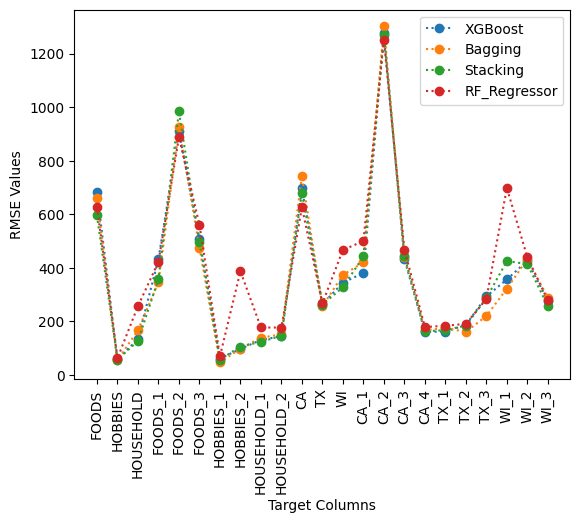

In [25]:
target_cols = ['FOODS','HOBBIES','HOUSEHOLD','FOODS_1','FOODS_2','FOODS_3','HOBBIES_1','HOBBIES_2','HOUSEHOLD_1',
               'HOUSEHOLD_2','CA', 'TX','WI','CA_1','CA_2', 'CA_3','CA_4', 'TX_1', 'TX_2', 'TX_3','WI_1','WI_2', 'WI_3']  

XGBoost = [684.5201518781283, 58.32733658907493, 133.43926140001807, 432.27354609851494, 910.3908680489494, 
                506.78743602515453, 60.8622305373713, 96.89834073141365, 130.46233828315331, 144.22878194526086, 
                696.4173183222433, 264.2913221138851, 344.33383229528016, 380.4926819621933, 1276.8889879924964, 
                432.8312179600542, 161.1345705527386, 161.4462891527314, 186.5938990504928, 292.93124724825554, 
                356.38277625452577, 426.3690554448898, 277.1735669399432]

Bagging = [658.8102849331476, 55.433439682131464, 165.97897202010964, 345.8699716991141, 925.228487183954, 
               474.80221120287734, 46.46854076152143, 97.82103218555623, 138.6758167808733, 151.39792802276364, 
               743.6384751084347, 256.08298820570775, 373.1195584400961, 420.3021208629403, 1301.432930106316, 
               439.63596372481373, 166.91434936063823, 174.79945210450302, 160.41951450339675, 219.86665617502976, 
               322.13404994399076, 432.28334927148603, 288.37137697853217]

Stacking = [595.507174429319, 56.409265688546775, 126.94033565664685, 356.86626415714414, 983.7996527412449, 
            495.4830393432965, 56.92251452223829, 105.8728796852712, 123.2754222116051, 146.009488626472, 
            680.6572166263741, 262.64642932613253, 327.08592544028795, 442.31215840655796, 1270.2362588853962, 
            445.0209901599056, 162.5979809497748, 166.9886968461545, 184.1980911654955, 286.4085760611746, 
            424.9553886337423, 413.9047181932017, 256.70817059808843]

RF_Regressor = [627.3532723343671, 61.758482773645106, 256.54148181815646, 421.76245512229434, 887.717741046583, 
               560.510961326841, 69.18899978770494, 387.0589292079194, 177.06062308463845, 176.5113281274883, 
               626.5962857347598, 267.07718729822454, 466.43248809952337, 499.7887126505879, 1251.5735015651926,
               468.17863408323313, 178.55342397396703, 183.4916998836133, 190.46807963939344, 283.59175479359584, 
               697.8609639063076, 438.7109411023754, 277.8611247326555]

plt.plot(target_cols, XGBoost, marker='o', linestyle='dotted', label="XGBoost")
plt.plot(target_cols, Bagging, marker='o', linestyle='dotted', label="Bagging")
plt.plot(target_cols, Stacking, marker='o', linestyle='dotted', label="Stacking")
plt.plot(target_cols, RF_Regressor, marker='o', linestyle='dotted', label="RF_Regressor")
plt.xlabel("Target Columns")
plt.ylabel("RMSE Values")
plt.legend()
plt.xticks(rotation=90)
plt.show()

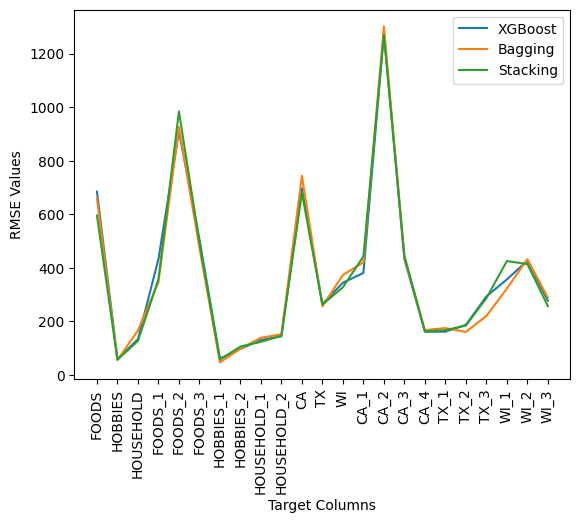

In [26]:
target_cols = ['FOODS','HOBBIES','HOUSEHOLD','FOODS_1','FOODS_2','FOODS_3','HOBBIES_1','HOBBIES_2','HOUSEHOLD_1',
               'HOUSEHOLD_2','CA', 'TX','WI','CA_1','CA_2', 'CA_3','CA_4', 'TX_1', 'TX_2', 'TX_3','WI_1','WI_2', 'WI_3']  

XGBoost = [684.5201518781283, 58.32733658907493, 133.43926140001807, 432.27354609851494, 910.3908680489494, 
                506.78743602515453, 60.8622305373713, 96.89834073141365, 130.46233828315331, 144.22878194526086, 
                696.4173183222433, 264.2913221138851, 344.33383229528016, 380.4926819621933, 1276.8889879924964, 
                432.8312179600542, 161.1345705527386, 161.4462891527314, 186.5938990504928, 292.93124724825554, 
                356.38277625452577, 426.3690554448898, 277.1735669399432]

Bagging = [658.8102849331476, 55.433439682131464, 165.97897202010964, 345.8699716991141, 925.228487183954, 
               474.80221120287734, 46.46854076152143, 97.82103218555623, 138.6758167808733, 151.39792802276364, 
               743.6384751084347, 256.08298820570775, 373.1195584400961, 420.3021208629403, 1301.432930106316, 
               439.63596372481373, 166.91434936063823, 174.79945210450302, 160.41951450339675, 219.86665617502976, 
               322.13404994399076, 432.28334927148603, 288.37137697853217]

Stacking = [595.507174429319, 56.409265688546775, 126.94033565664685, 356.86626415714414, 983.7996527412449, 
            495.4830393432965, 56.92251452223829, 105.8728796852712, 123.2754222116051, 146.009488626472, 
            680.6572166263741, 262.64642932613253, 327.08592544028795, 442.31215840655796, 1270.2362588853962, 
            445.0209901599056, 162.5979809497748, 166.9886968461545, 184.1980911654955, 286.4085760611746, 
            424.9553886337423, 413.9047181932017, 256.70817059808843]

plt.plot(target_cols, XGBoost, label="XGBoost")
plt.plot(target_cols, Bagging,label="Bagging")
plt.plot(target_cols, Stacking, label="Stacking")
plt.xlabel("Target Columns")
plt.ylabel("RMSE Values")
plt.legend()
plt.xticks(rotation=90)
plt.show()

### LightGBM model

In [15]:
df.drop(columns = ['ds'], inplace = True)
df

,FOODS,HOBBIES,HOUSEHOLD,FOODS_1,FOODS_2,FOODS_3,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2,...,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,23178,3764,5689,2343,4094,16741,3610,154,4105,1584,...,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038
2011-01-30,22758,3357,5634,2216,4209,16333,3172,185,3858,1776,...,4155,3046,4827,1777,2687,3937,3006,2194,1922,4198
2011-01-31,17174,2682,3927,1657,3174,12343,2497,185,2827,1100,...,2816,2121,3785,1386,1822,2731,2225,1562,2018,3317
2011-02-01,18878,2669,3865,1508,3606,13764,2531,138,2732,1133,...,3051,2324,4232,1440,2258,2954,2169,1251,2522,3211
2011-02-02,14603,1814,2729,1209,2869,10525,1714,100,1802,927,...,2630,1942,3817,1536,1694,2492,1726,2,1175,2132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-20,23632,3472,8239,2657,4734,16241,3141,331,6393,1846,...,3722,3691,5235,2500,2901,3384,3315,3242,4194,3159
2016-04-21,23317,3353,8363,2639,4446,16232,3014,339,6580,1783,...,3709,3303,5018,2458,2776,3446,3380,3324,4393,3226
2016-04-22,26704,4085,9728,3169,4974,18561,3678,407,7762,1966,...,4387,4457,5623,2628,3022,3902,3691,3991,4988,3828


In [16]:
#Create lag_cols, lag by timestep 1 and backfill with the next immediate values to match dimensions.
#Lagged columns are lagged features or features for the data frame. 

lag_cols = ['FOODS', 'HOBBIES', 'HOUSEHOLD', 'FOODS_1', 'FOODS_2', 'FOODS_3','HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'CA','TX', 'WI', 'CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1','WI_2', 'WI_3']
for col in lag_cols:
    df[f'lag_1_{col}'] = df[col].shift(1)

df = df.bfill()
#df

In [17]:
# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train_data = df[:train_size]
test_data = df[train_size:]

In [18]:
# Now our target variables are the main data frame columns.
# We are labeling main target variables in dataframe as target variables if the difference in time by 1 step matches.

target_cols = ['FOODS','HOBBIES','HOUSEHOLD','FOODS_1','FOODS_2','FOODS_3','HOBBIES_1','HOBBIES_2','HOUSEHOLD_1',
               'HOUSEHOLD_2','CA', 'TX','WI','CA_1','CA_2', 'CA_3','CA_4', 'TX_1', 'TX_2', 'TX_3','WI_1','WI_2', 'WI_3']  

feature_cols = [col for col in df.columns if col not in target_cols]

train_dataset = lgb.Dataset(train_data[feature_cols], label=train_data[target_cols])
test_dataset = lgb.Dataset(test_data[feature_cols], label=test_data[target_cols])

In [19]:
# Since we have continous values, this problem is treated as regression. MSE is appropriate metric for regression. 
#`num_leaves --> represents the maximum number of leaves in a tree. A leaf is a node that does not have any child nodes. 
#A common practice is to set `num_leaves` to a value between 2^(max_depth) and 2^(max_depth+1)
# Maximum no. of levels is max_depth. Reduce no. of leaves for better accuracy.

params = {
    'objective': 'regression',
    'metric': 'mse',
    'learning_rate': 0.1,
    'num_leaves': 20,
    'max_depth': -1
}

In [20]:
models = {}  # Dictionary to store the trained models
rmse_values = {}  # Dictionary to store the RMSE values
mape_values = {} # Dictionary to store the MAPE values

In [21]:
# Train separate models for each target variable

for target_col in target_cols:
    train_label = train_data[target_col]
    test_label = test_data[target_col]

    train_dataset = lgb.Dataset(train_data[feature_cols], label=train_label)
    test_dataset = lgb.Dataset(test_data[feature_cols], label=test_label)

    # Train the model
    model = lgb.train(params, train_dataset, num_boost_round=100)
    models[target_col] = model

    # Evaluate the model
    predictions = model.predict(test_data[feature_cols])
    mse = np.mean((predictions - test_label) ** 2)
    rmse = math.sqrt(mse)
    rmse_values[target_col] = rmse
    mape = mean_absolute_percentage_error(predictions, test_label)
    mape_values[target_col] = mape
    
    print("RMSE for {}: {}".format(target_col, rmse))
    print("MAPE for {}: {}".format(target_col, mape))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 1530, number of used features: 23
[LightGBM] [Info] Start training from score 23018.371895
RMSE for FOODS: 3319.590534537011
MAPE for FOODS: 0.09091077691144361
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 1530, number of used features: 23
[LightGBM] [Info] Start training from score 3031.590196
RMSE for HOBBIES: 584.3977140491161
MAPE for HOBBIES: 0.11827352723345877
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_col_wise=true` to remove the overhe

RMSE for TX_3: 507.97801283937685
MAPE for TX_3: 0.10200320362249844
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 1530, number of used features: 23
[LightGBM] [Info] Start training from score 2469.333333
RMSE for WI_1: 741.5630069409465
MAPE for WI_1: 0.16294895391730482
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 1530, number of used features: 23
[LightGBM] [Info] Start training from score 3163.579739
RMSE for WI_2: 843.1657277152618
MAPE for WI_2: 0.14967781544222253
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000548 sec

In [22]:
#print("All RMSE values:", rmse_values)
print("All MAPE values:", mape_values)

All MAPE values: {'FOODS': 0.09091077691144361, 'HOBBIES': 0.11827352723345877, 'HOUSEHOLD': 0.1235144622867449, 'FOODS_1': 0.10572269625455849, 'FOODS_2': 0.15233138721282272, 'FOODS_3': 0.10055726614762359, 'HOBBIES_1': 0.12509637324760825, 'HOBBIES_2': 0.15823351797733531, 'HOUSEHOLD_1': 0.12792797140815435, 'HOUSEHOLD_2': 0.12217680792708539, 'CA': 0.10649343419976694, 'TX': 0.08552026491708285, 'WI': 0.13183331115512084, 'CA_1': 0.11889128254299847, 'CA_2': 0.2981434948889195, 'CA_3': 0.09077905707803564, 'CA_4': 0.07814194516723272, 'TX_1': 0.09894355862220598, 'TX_2': 0.10408417529178975, 'TX_3': 0.10200320362249844, 'WI_1': 0.16294895391730482, 'WI_2': 0.14967781544222253, 'WI_3': 0.13709253306992422}


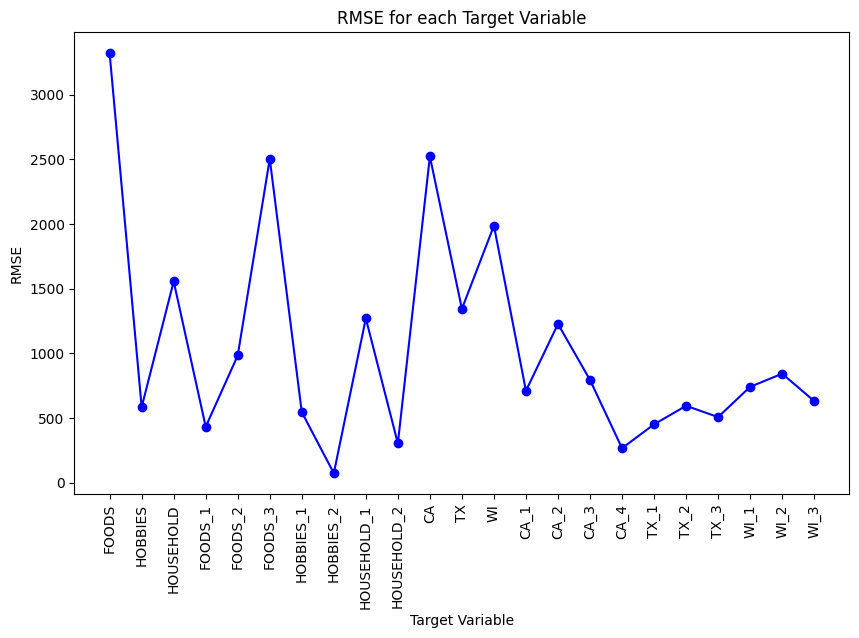

In [23]:
# Plot RMSE values against each target variable
plt.figure(figsize=(10, 6))
plt.plot(list(rmse_values.keys()), list(rmse_values.values()), marker='o', linestyle='-', color='blue')
plt.xlabel('Target Variable')
plt.ylabel('RMSE')
plt.title('RMSE for each Target Variable')
plt.xticks(rotation=90)
plt.show()

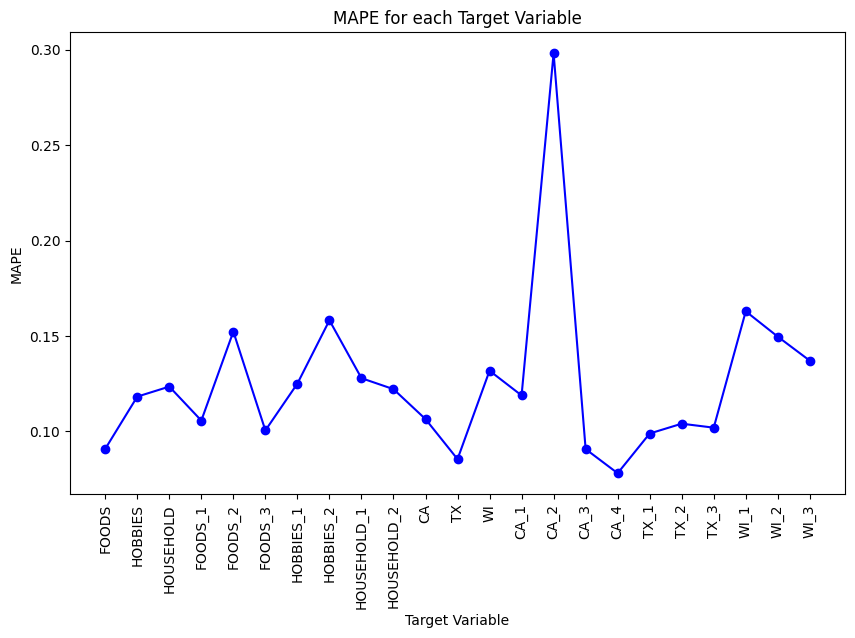

In [24]:
# Plot RMSE values against each target variable
plt.figure(figsize=(10, 6))
plt.plot(list(mape_values.keys()), list(mape_values.values()), marker='o', linestyle='-', color='blue')
plt.xlabel('Target Variable')
plt.ylabel('MAPE')
plt.title('MAPE for each Target Variable')
plt.xticks(rotation=90)
plt.show()

### COMPARISION OF ALL MODELS

### <center> RMSE

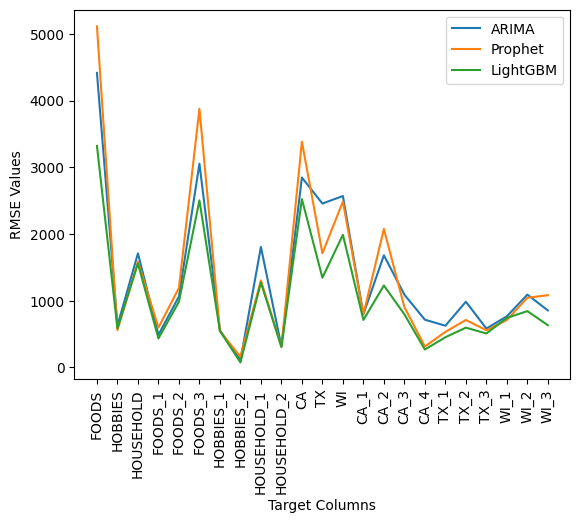

In [25]:
target_cols = ['FOODS','HOBBIES','HOUSEHOLD','FOODS_1','FOODS_2','FOODS_3','HOBBIES_1','HOBBIES_2','HOUSEHOLD_1',
               'HOUSEHOLD_2','CA', 'TX','WI','CA_1','CA_2', 'CA_3','CA_4', 'TX_1', 'TX_2', 'TX_3','WI_1','WI_2', 'WI_3']  

ARIMA = [4414.427801036455,625.0129703702443,1708.9953500272914,487.1101013596283,1062.1228870227712,3053.347541667216,
  555.4494543218098,107.7151437045555,1805.211932364774,314.772886635246,2845.1658686836577,2455.6378820617315,2568.189448239621,
  796.0200794610948,1679.6588711859101,1089.7251686454244,714.4705377660863,624.2840181834466,983.8099082992557,
  582.2712860138937,765.2309697498303,1090.065208980127,853.7038134989234]
Prophet =  [5110.8235284834445, 558.8647341927426, 1585.081735746497, 595.9981400812075, 1191.0193788538754, 3876.755636485078, 
            543.9021764641608, 160.33901493306325, 1303.2539654376048, 311.0364441083963, 3382.0284501647966, 
            1710.260102149567, 2485.536906698374, 792.7791747591133, 2074.6689294284483, 903.3300883035496, 
            312.77741656797383, 531.7544317221472, 710.301955475194, 556.4151381998163, 709.4270412204864, 
            1043.5941966349826, 1081.5826116893172]
LightGBM = [3319.590534537011,584.3977140491161, 1556.3873564216303, 433.0666251027355, 983.883585620006, 2503.339659573278,
            546.1107184801933,74.0229975877067,1270.1774091024874,304.5712510724757, 2522.012126488803, 1344.2516137774141,
            1986.7149140411043,710.8527467603836, 1227.410039106039, 794.9171988255989, 267.32320301143085, 451.72115419990445,
            595.0289127363693, 507.97801283937685,741.5630069409465, 843.1657277152618, 631.853972936856]

plt.plot(target_cols, ARIMA, label="ARIMA")
plt.plot(target_cols, Prophet, label="Prophet")
plt.plot(target_cols, LightGBM, label="LightGBM")
plt.xlabel("Target Columns")
plt.ylabel("RMSE Values")
plt.legend()
plt.xticks(rotation=90)
plt.show()

 ### <center> MAPE 

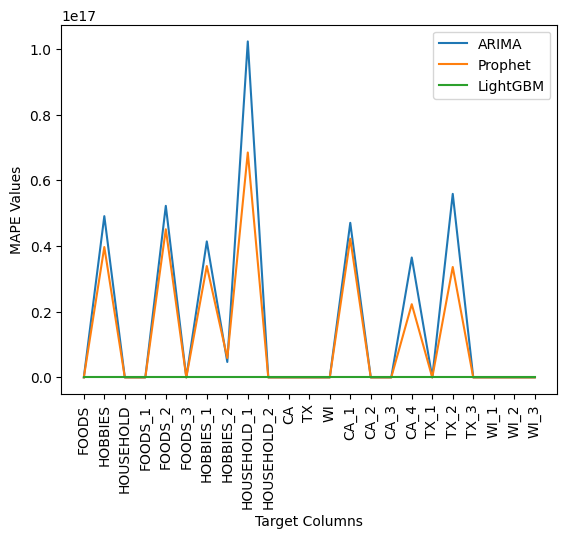

In [26]:
target_cols = ['FOODS','HOBBIES','HOUSEHOLD','FOODS_1','FOODS_2','FOODS_3','HOBBIES_1','HOBBIES_2','HOUSEHOLD_1',
               'HOUSEHOLD_2','CA', 'TX','WI','CA_1','CA_2', 'CA_3','CA_4', 'TX_1', 'TX_2', 'TX_3','WI_1','WI_2', 'WI_3'] 
ARIMA = [4.552398391956181,4.909902140005632e+16,21.267312736323365,8.06251557292648,5.223556724520484e+16,3.6430120788858784,
  4.140351401850404e+16,4706108864513807.0,1.0229238476963355e+17,5.02294043021412,6.609414302589637,8.242927970195646,
  6.970185839792852,4.7063467144308776e+16,3.1274917598288345,4.321603542453432,3.650373034238475e+16,8.782219074654996,
  5.588247325798659e+16,3.3427401181554357,4.313065951889741,10.278232893904914,8.21972392522621]

Prophet = [3.99210937291565, 3.9691575402403624e+16, 19.25785074713275, 7.404256954580688, 4.5102391159932344e+16, 
           2.8077851936001212, 3.392133001457955e+16, 5919047719780340.0, 6.847756335045825e+16, 4.0406680748275186, 
           5.201140553356924, 5.671856052364931, 6.053214668006202, 4.223807952361279e+16, 2.1972074429071773, 
           3.2130101947456073, 2.229458591990114e+16, 6.9712924887946, 3.3624949938388588e+16, 2.8330835813912802, 4.636563812586893, 
           9.528352523287227, 5.836580526735573]
LightGBM = [0.09091077691144361, 0.11827352723345877, 0.1235144622867449, 0.10572269625455849,0.15233138721282272, 
            0.10055726614762359,0.12509637324760825,0.15823351797733531,0.12792797140815435,0.12217680792708539, 
            0.10649343419976694,0.08552026491708285,0.13183331115512084, 0.11889128254299847, 0.2981434948889195, 
            0.09077905707803564, 0.07814194516723272,0.09894355862220598,0.10408417529178975,0.10200320362249844, 0.16294895391730482, 
            0.14967781544222253, 0.13709253306992422]

plt.plot(target_cols, ARIMA, label="ARIMA")
plt.plot(target_cols, Prophet, label="Prophet")
plt.plot(target_cols, LightGBM, label="LightGBM")
plt.xlabel("Target Columns")
plt.ylabel("MAPE Values")
plt.legend()
plt.xticks(rotation=90)
plt.show()
